# Imports

In [243]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# file management imports
import os  ### only for count of images from dir, can be removed later

# image processing imports
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# model imports for deep learning 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
import keras
from keras import optimizers
from keras.utils.np_utils import to_categorical 
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


#for displaying images when predicting class
from PIL import Image 
#for rounding up fitting model for steps_per_epoch
import math

from keras.models import load_model



# Loading data

In [244]:
#loading train and test datasets from directory ../shapes
train_dir = 'shapes/train'
test_dir = 'shapes/valid'



#Location of train and test sets of circle
train_dir_circle = train_dir+'/circle'
test_dir_circle = test_dir+'/circle'
#Location of train and test sets of square
train_dir_square = train_dir+'/square'
test_dir_square = test_dir+'/square'
#Location of train and test sets of triangle
train_dir_triangle = train_dir+'/triangle'
test_dir_triangle = test_dir+'/triangle'
#Location of train and test sets of stars
train_dir_stars = train_dir+'/stars'
test_dir_stars = test_dir+'/stars'

### i used a terminal command for spliting the stars dataset into train and test sets ### similar to this - %mv $(ls | sort -R | head -920) (directory)


# EDA

In [4]:
#checking the amount of images in each set
print('Total number of images in circle training set: ', len(os.listdir(train_dir_circle)))
print('Total number of images in circle test set:     ', len(os.listdir(test_dir_circle)))
print('Total number of images in square training set: ', len(os.listdir(train_dir_square)))
print('Total number of images in square test set:     ', len(os.listdir(test_dir_square)))
print('Total number of images in triangle training set:', len(os.listdir(train_dir_triangle)))
print('Total number of images in triangle test set:     ', len(os.listdir(test_dir_triangle)))
print('Total number of images in stars training set:', len(os.listdir(train_dir_stars)))
print('Total number of images in stars test set:     ', len(os.listdir(test_dir_stars)))

Total number of images in circle training set:  996
Total number of images in circle test set:      111
Total number of images in square training set:  1004
Total number of images in square test set:      111
Total number of images in triangle training set: 999
Total number of images in triangle test set:      111
Total number of images in stars training set: 1002
Total number of images in stars test set:      112


In [245]:
#checking the amount of images in each set
print('Total number of images in circle training set: ', len(os.listdir(train_dir_circle)))
print('Total number of images in circle test set:     ', len(os.listdir(test_dir_circle)))
print('Total number of images in square training set: ', len(os.listdir(train_dir_square)))
print('Total number of images in square test set:     ', len(os.listdir(test_dir_square)))
print('Total number of images in triangle training set:', len(os.listdir(train_dir_triangle)))
print('Total number of images in triangle test set:     ', len(os.listdir(test_dir_triangle)))
print('Total number of images in stars training set:', len(os.listdir(train_dir_stars)))
print('Total number of images in stars test set:     ', len(os.listdir(test_dir_stars)))

Total number of images in circle training set:  1013
Total number of images in circle test set:      114
Total number of images in square training set:  1014
Total number of images in square test set:      113
Total number of images in triangle training set: 1009
Total number of images in triangle test set:      113
Total number of images in stars training set: 1002
Total number of images in stars test set:      112


In [246]:
#display image smaller (for checking manually)
def display_image(image_directory):
    im = image.load_img(image_directory)
    fig, ax = plt.subplots(figsize=(4,4))
    # displaying the image with figsize
    ax.imshow(im)

collage of sample images from circle folder


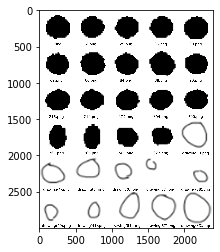

In [247]:
print('collage of sample images from circle folder')
display_image('collages/EDA_circles.jpg')

collage of sample images from square folder


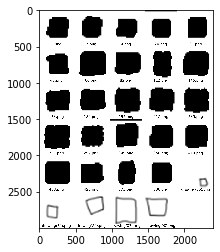

In [248]:
print('collage of sample images from square folder')
display_image('collages/EDA_squares.jpg')

collage of sample images from triangle folder


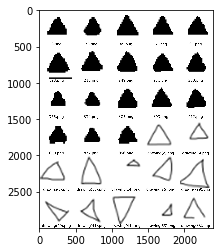

In [249]:
print('collage of sample images from triangle folder')
display_image('collages/EDA_triangles.jpg')

collage of sample images from star folder


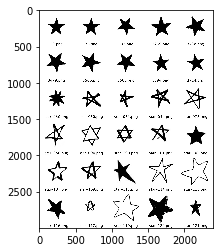

In [250]:
print('collage of sample images from star folder')
display_image('collages/EDA_stars.jpg')

# Generator for image augmentation.

In [295]:
data_generator = ImageDataGenerator(        # Randomly augmentates, with effects below, through each image per epoch  
    
                                    rescale = 1.0/255.0,   # rescales image by multipling each pixel by this fraction
                                    fill_mode = 'constant', # fills pixel at the edge to the nearest color (good for if the image is rotated or cropped weird)
                                    zoom_range = 0.2,      # can randomly apply a zoom to the image (from 0 to 20%)
                                    rotation_range = 30,   # can randomly apply a rotation to the image (from 0 to 45 degrees)
                                    shear_range = 0.03,    # can randomly add skew to the image had to add to help with angling of the photos
                                    horizontal_flip=True,  # can randomly flips the image on the x-axis
                                    vertical_flip=True,    # can randomly flips the image on the y-axis
                                    )

# Fit generator to training and testing sets

In [252]:
# classes= ['Circle','Square','Triangle', 'Stars']
batch_size = 32

#making tensorflow for training data
training_data = data_generator.flow_from_directory(directory= train_dir,       # dataset
                                                   target_size = (64,64),      # desired dimensions for the images
                                                   batch_size = batch_size,    # it will be run in groups of(batch_size specified above)
                                                   class_mode = 'categorical', # type of classifiaction
                                                   shuffle=False)
#making tensorflow for testing data
testing_data = data_generator.flow_from_directory(directory= test_dir,
                                                   target_size = (64,64),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   shuffle=False)



Found 4034 images belonging to 4 classes.
Found 448 images belonging to 4 classes.


In [253]:
# preparing model for final layer in the Neural Net
num_classes = len(set(training_data.classes))
num_classes

4

# Building CNN model

In [254]:
model = Sequential()
    #first block
#first convolutional layer
model.add(Conv2D(filters = 16,          # first layer should have the lowest filter size
                 kernel_size = (3, 3),  # kernel_size = (3, 3) b/c image size smaller then 128x128
                 activation = 'relu',
                 padding="same",
                 input_shape = training_data.image_shape))  # first layer needs a input_shape (set it to size of training image)
#second convolutional layer
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding="same",activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2)))
model.add(Dropout(rate = 0.2))
    #second block
#third convolutional layer
model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding="same", activation = 'relu'))
#fourth convolutional layer
model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2)))
model.add(Dropout(rate = 0.2))
    #third block
#fifth convolutional layer
model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding="same", activation = 'relu'))
#last convolutional layer (last layer should have the highest filter size)
model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2)))
model.add(Dropout(rate = 0.3))
# this converts our 3D feature maps to 1D feature vectors
model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.5))


#output layer
model.add(Dense(units = num_classes, activation = 'softmax'))
#optimizer for compiler
Adam=keras.optimizers.Adam(lr=0.01)

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy','mse'])

In [255]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)       

# Fit model to training and testing sets

In [256]:
total_training_size = len(os.listdir(train_dir_circle))+len(os.listdir(train_dir_square))+len(os.listdir(train_dir_triangle))+len(os.listdir(train_dir_stars))
total_testing_size = len(os.listdir(test_dir_circle))+len(os.listdir(test_dir_square))+len(os.listdir(test_dir_triangle))+len(os.listdir(test_dir_stars))

print(f"Total # of images in training set: {total_training_size}")
print(f"Total # of images in testing set: {total_testing_size}")





Total # of images in training set: 4038
Total # of images in testing set: 452


In [257]:
#Trains the model on the data batch-by-batch (bit-by-bit)
fitted_model = model.fit_generator(training_data,
                                  steps_per_epoch = math.ceil(total_training_size//batch_size), # general rule: should be total datapoints divided by batch size ([2999/32] rounded up)
                                  epochs = 50,            
                                  validation_data = (testing_data),
                                  validation_steps = total_testing_size,
                                  max_queue_size = 10
                                  )

Epoch 1/50
126/126 [==============================] - 64s 507ms/step - loss: 1.3858 - accuracy: 0.2551 - mse: 0.1872 - val_loss: 1.2706 - val_accuracy: 0.5067 - val_mse: 0.1730
Epoch 2/50
126/126 [==============================] - 71s 561ms/step - loss: 0.9423 - accuracy: 0.5680 - mse: 0.1322 - val_loss: 0.7781 - val_accuracy: 0.6081 - val_mse: 0.1153
Epoch 3/50
126/126 [==============================] - 60s 475ms/step - loss: 0.7407 - accuracy: 0.6704 - mse: 0.1060 - val_loss: 0.7738 - val_accuracy: 0.6296 - val_mse: 0.1142
Epoch 4/50
126/126 [==============================] - 58s 461ms/step - loss: 0.5948 - accuracy: 0.7534 - mse: 0.0828 - val_loss: 0.4711 - val_accuracy: 0.7921 - val_mse: 0.0681
Epoch 5/50
126/126 [==============================] - 58s 457ms/step - loss: 0.5255 - accuracy: 0.7916 - mse: 0.0739 - val_loss: 0.3976 - val_accuracy: 0.8289 - val_mse: 0.0574
Epoch 6/50
126/126 [==============================] - 58s 464ms/step - loss: 0.4171 - accuracy: 0.8251 - mse: 0.057

126/126 [==============================] - 61s 481ms/step - loss: 0.0757 - accuracy: 0.9750 - mse: 0.0095 - val_loss: 0.0277 - val_accuracy: 0.9917 - val_mse: 0.0036
Epoch 48/50
126/126 [==============================] - 59s 465ms/step - loss: 0.0793 - accuracy: 0.9728 - mse: 0.0102 - val_loss: 0.0289 - val_accuracy: 0.9909 - val_mse: 0.0036
Epoch 49/50
126/126 [==============================] - 58s 461ms/step - loss: 0.1016 - accuracy: 0.9685 - mse: 0.0120 - val_loss: 0.0366 - val_accuracy: 0.9882 - val_mse: 0.0048
Epoch 50/50
126/126 [==============================] - 58s 458ms/step - loss: 0.0688 - accuracy: 0.9732 - mse: 0.0091 - val_loss: 0.0301 - val_accuracy: 0.9916 - val_mse: 0.0036


In [455]:
# Trains the model on the data batch-by-batch (bit-by-bit) (@ 3times the epochs)
fitted_model = model.fit_generator(training_data,
                                  steps_per_epoch = math.ceil((total_training_size//batch_size)*3), # general rule: should be total datapoints divided by batch size ([2999/32] rounded up)
                                  epochs = 100,            
                                  validation_data = (testing_data),
                                  validation_steps = total_testing_size,
                                  max_queue_size = 10
                                  )

Epoch 1/100
375/375 [==============================] - 105s 281ms/step - loss: 0.0698 - accuracy: 0.9737 - mse: 0.0092 - val_loss: 0.0287 - val_accuracy: 0.9900 - val_mse: 0.0037
Epoch 2/100
375/375 [==============================] - 103s 273ms/step - loss: 0.0679 - accuracy: 0.9761 - mse: 0.0086 - val_loss: 0.0305 - val_accuracy: 0.9917 - val_mse: 0.0038
Epoch 3/100
375/375 [==============================] - 104s 277ms/step - loss: 0.0718 - accuracy: 0.9761 - mse: 0.0088 - val_loss: 0.0277 - val_accuracy: 0.9909 - val_mse: 0.0035
Epoch 4/100
375/375 [==============================] - 103s 275ms/step - loss: 0.0635 - accuracy: 0.9782 - mse: 0.0083 - val_loss: 0.0355 - val_accuracy: 0.9877 - val_mse: 0.0047
Epoch 5/100
375/375 [==============================] - 104s 279ms/step - loss: 0.0627 - accuracy: 0.9780 - mse: 0.0081 - val_loss: 0.0199 - val_accuracy: 0.9947 - val_mse: 0.0024
Epoch 6/100
375/375 [==============================] - 105s 280ms/step - loss: 0.0584 - accuracy: 0.9786 

Epoch 91/100
375/375 [==============================] - 104s 277ms/step - loss: 0.0316 - accuracy: 0.9904 - mse: 0.0038 - val_loss: 0.0062 - val_accuracy: 0.9985 - val_mse: 7.0153e-04
Epoch 92/100
375/375 [==============================] - 105s 281ms/step - loss: 0.0374 - accuracy: 0.9891 - mse: 0.0043 - val_loss: 0.0058 - val_accuracy: 0.9987 - val_mse: 6.1262e-04
Epoch 93/100
375/375 [==============================] - 104s 277ms/step - loss: 0.0337 - accuracy: 0.9886 - mse: 0.0040 - val_loss: 0.0058 - val_accuracy: 0.9984 - val_mse: 6.7473e-04
Epoch 94/100
375/375 [==============================] - 104s 278ms/step - loss: 0.0293 - accuracy: 0.9907 - mse: 0.0035 - val_loss: 0.0073 - val_accuracy: 0.9988 - val_mse: 6.5693e-04
Epoch 95/100
375/375 [==============================] - 104s 278ms/step - loss: 0.0302 - accuracy: 0.9912 - mse: 0.0036 - val_loss: 0.0053 - val_accuracy: 0.9985 - val_mse: 6.3055e-04
Epoch 96/100
375/375 [==============================] - 105s 279ms/step - loss: 

# Save model

In [454]:
tf.keras.models.save('models/MAIN-STARS_model_50_epochs_with_rescaler_zoom-0.2_rotation-45_skew-0.05_flip-hori_verti-02-main.h5')  # save your weights and model after training

## Load model

In [101]:
# model = Sequential()
tf.keras.models.load_model('models/MAIN-STARS_model_50_epochs_with_rescaler_zoom-0.2_rotation-45_skew-0.02_flip-hori_verti-02-main.h5')

# Plotting metrics from model

In [259]:
#getting and labeling the evaluations to plot
accuracy = fitted_model.history['accuracy'][1:]
loss = fitted_model.history['loss'][1:]
val_accuracy = fitted_model.history['val_accuracy'][1:]
val_loss = fitted_model.history['val_loss'][1:]
mse = fitted_model.history['mse'][1:]


## Plot Accuracy vs Loss

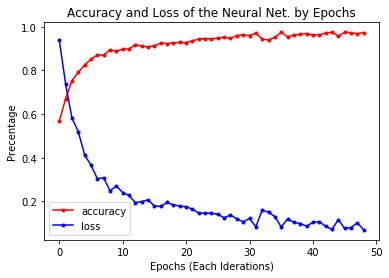

In [260]:
#plot accuracy for model
plt.plot(range(len(accuracy)), accuracy, 'r', marker= '.', label = 'accuracy')
#plot loss for model
plt.plot(range(len(loss)), loss, 'b', marker= '.', label = 'loss')
plt.xlabel('Epochs (Each Iderations)')
plt.ylabel('Precentage')
plt.title('Accuracy and Loss of the Neural Net. by Epochs')
plt.legend()

## Plot Cross Validation Accuracy vs Cross Validation Loss

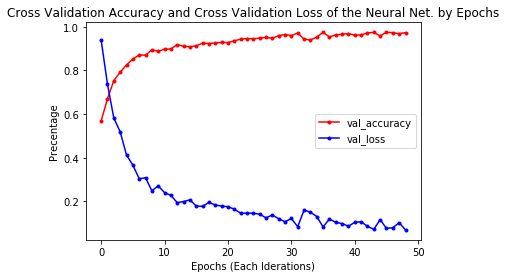

In [261]:
#plot cross validation accuracy for model
plt.plot(range(len(val_accuracy)), accuracy, 'r', marker= '.', label = 'val_accuracy')
#plot cross validation loss for model
plt.plot(range(len(val_loss)), loss, 'b', marker= '.', label = 'val_loss')
plt.xlabel('Epochs (Each Iderations)')
plt.ylabel('Precentage')
plt.title('Cross Validation Accuracy and Cross Validation Loss of the Neural Net. by Epochs')
plt.legend()

## Plot Mean Squared Error vs Loss

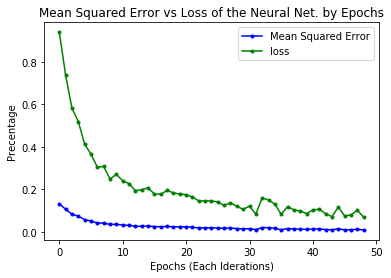

In [262]:
#plot mean squared error for model
plt.plot(range(len(mse)), mse, 'b', marker= '.', label = 'Mean Squared Error')
#plot accuracy for model
plt.plot(range(len(loss)), loss, 'g', marker= '.', label = 'loss')
plt.xlabel('Epochs (Each Iderations)')
plt.ylabel('Precentage')
plt.title('Mean Squared Error vs Loss of the Neural Net. by Epochs')
plt.legend()

## Plot Cross Validation Accuracy vs Mean Squared Error

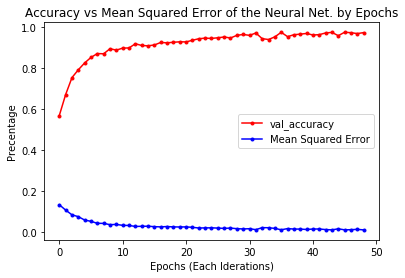

In [263]:
#plot cross validation accuracy for model
plt.plot(range(len(val_accuracy)), accuracy, 'r', marker= '.', label = 'val_accuracy')
#plot mean squared error for model
plt.plot(range(len(mse)), mse, 'b', marker= '.', label = 'Mean Squared Error')
plt.xlabel('Epochs (Each Iderations)')
plt.ylabel('Precentage')
plt.title('Accuracy vs Mean Squared Error of the Neural Net. by Epochs')
# plt.xticks(ticks=np.arange(2,25)
plt.legend()

# Confusion Matrix

In [264]:
import itertools    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [265]:
test_set=test_dir_circle+test_dir_square+test_dir_triangle+test_dir_stars

In [266]:
# predicted_classes = np.argmax(predictions, axis=1)
true_classes = testing_data.classes
class_labels = list(testing_data.class_indices.keys()) 
print(class_labels)
print(true_classes)

['circle', 'square', 'stars', 'triangle']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3]


In [267]:
testing_data
predictions = model.predict_generator(testing_data)
predicted_classes = np.argmax(predictions, axis=1)


In [268]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

              precision    recall  f1-score   support

      circle       0.99      0.98      0.99       113
      square       1.00      0.99      1.00       112
       stars       1.00      0.99      1.00       111
    triangle       0.97      1.00      0.99       112

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



In [269]:
cm = metrics.confusion_matrix(true_classes, predicted_classes)

Confusion Matrix, without normalization
[[111   0   0   2]
 [  1 111   0   0]
 [  0   0 110   1]
 [  0   0   0 112]]


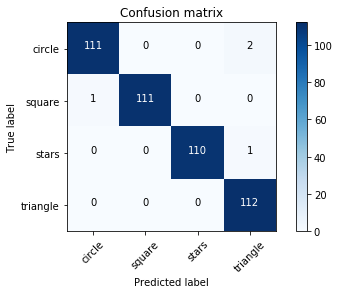

In [270]:
plot_confusion_matrix(cm,class_labels)

# testing the model

In [271]:
#checking the labels for the classification 
train_labels = training_data.classes
train_labels = to_categorical(train_labels,num_classes)
# validation_labels = training_data.classes
# validation_labels = to_categorical(validation_labels,num_classes)
train_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [272]:
#function for predicting category of slected image
def testing_image(image_directory):

#     predicted_classes=
    
    # loading testing image with the target size for the image
    test_image = image.load_img(image_directory, target_size = (64,64))
    # makes sure the image is in RGB (converts all images to have only 3 color channels, png images have 4 color channels)
    test_image = test_image.convert(mode='RGB')
    # converts image into an array
    test_image = tf.keras.preprocessing.image.img_to_array(test_image)
    # expands array (from converted image) with a new dimension (for classifying values)
    test_image = np.expand_dims(test_image, axis = 0)
    # making prediction based on test_image and labeling it results
    result = model.predict(x = test_image)
    # printing predictions
    print(result)
    
    #display image smaller (for checking manually)
    display_image(image_directory)

    # computing category weither a shape is a rectangle, square or triangle


    if result[0][0] == 1:
        prediction = 'Circle'
        print(f'Predicted shape is {prediction}')
    elif result[0][1] == 1:
        prediction = 'Square'
        print(f'Predicted shape is {prediction}')
    elif result[0][3] == 1:
        prediction = 'Triangle'
        print(f'Predicted shape is {prediction}')
    elif result[0][2] == 1:
        prediction = 'Star'
        print(f'Predicted shape is {prediction}')
    

## Testing images grabbed online or drawn by hand

[[1. 0. 0. 0.]]
Predicted shape is Circle


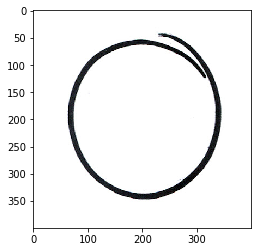

In [273]:
# print test image classified category
testing_image('images_to_predict/drawn_circle1.jpg')

[[1. 0. 0. 0.]]
Predicted shape is Circle


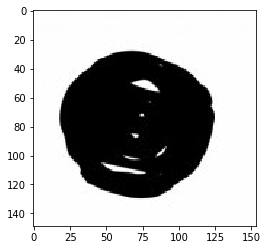

In [274]:
# print test image classified category
testing_image('images_to_predict/1_dot.png')

[[0. 0. 0. 1.]]
Predicted shape is Triangle


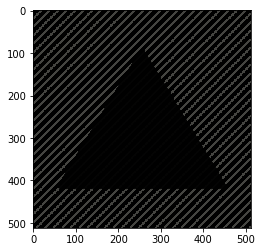

In [275]:
# print test image classified category
testing_image('images_to_predict/Triangle-3_-_Basic_UI_Glyph_Black-5-512.png')

[[0. 0. 0. 1.]]
Predicted shape is Triangle


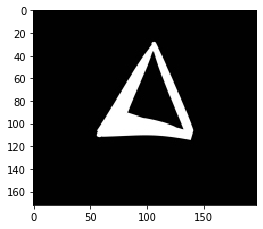

In [276]:
# print test image classified category
testing_image('images_to_predict/seamless-hand-drawn-triangle-pattern-with-black-and-white-png_75455.jpg')

[[0. 1. 0. 0.]]
Predicted shape is Square


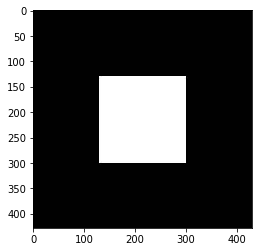

In [277]:
# print test image classified category
testing_image('images_to_predict/square-oq9l82oaujo11-01.jpg')

[[1. 0. 0. 0.]]
Predicted shape is Circle


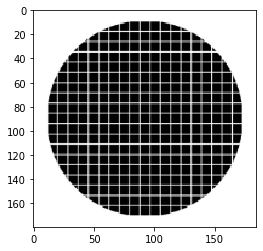

In [278]:
# print test image classified category
testing_image('images_to_predict/01_Circles_made_of_squares.png')


[[0. 1. 0. 0.]]
Predicted shape is Square


' this one predicts squares because the triangles are in a square formation'

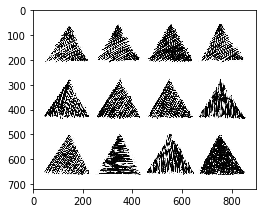

In [279]:
# print test image classified category
testing_image('images_to_predict/hand-drawn-pencil-scribble-triangles-andrii-shelenkov.jpg')


""" this one predicts squares because the triangles are in a square formation"""


[[0. 0. 0. 1.]]
Predicted shape is Triangle


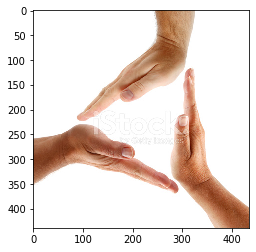

In [280]:
# print test image classified category
testing_image('images_to_predict/21063418-hands-in-triangle-shape.jpg')


[[0. 0. 0. 1.]]
Predicted shape is Triangle


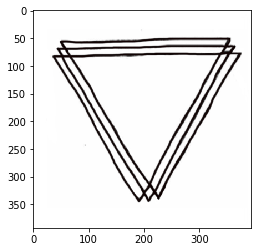

In [281]:
# print test image classified category
testing_image('images_to_predict/hand_drawn_prism.jpg')


[[0.99751043 0.00248953 0.         0.        ]]


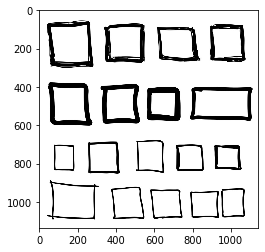

In [282]:
# print test image classified category
testing_image('images_to_predict/hand_drawn_squares.jpg')


[[0. 1. 0. 0.]]
Predicted shape is Square


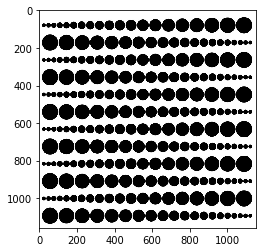

In [283]:
# print test image classified category
testing_image('images_to_predict/Screen Shot 2020-01-11 at 10.29.46 AM.png')


[[0. 0. 1. 0.]]
Predicted shape is Star


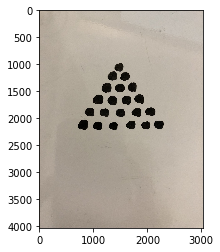

In [284]:
# print test image classified category
testing_image('images_to_predict/IMG_5265.jpg')


[[1.05830435e-10 1.00000000e+00 0.00000000e+00 0.00000000e+00]]
Predicted shape is Square


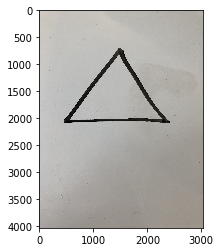

In [285]:
# print test image classified category
testing_image('images_to_predict/IMG_5257.jpg')


[[0. 0. 1. 0.]]
Predicted shape is Star


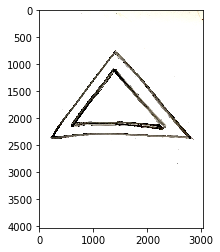

In [286]:
# print test image classified category
testing_image('images_to_predict/IMG_5254.jpg')


[[0. 0. 1. 0.]]
Predicted shape is Star


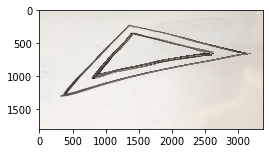

In [287]:
# print test image classified category
testing_image('images_to_predict/IMG_5255.jpg')


[[0. 0. 1. 0.]]
Predicted shape is Star


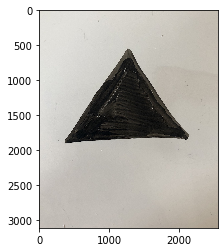

In [288]:
# print test image classified category
testing_image('images_to_predict/IMG_5258.jpg')


[[0. 1. 0. 0.]]
Predicted shape is Square


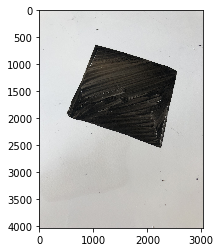

In [289]:
# print test image classified category
testing_image('images_to_predict/IMG_5259.jpg')


[[0. 0. 1. 0.]]
Predicted shape is Star


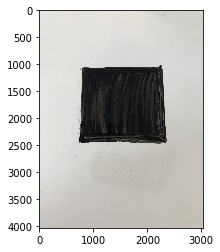

In [290]:
# print test image classified category
testing_image('images_to_predict/IMG_5260.jpg')


[[1. 0. 0. 0.]]
Predicted shape is Circle


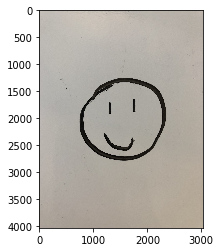

In [291]:
# print test image classified category
testing_image('images_to_predict/IMG_5261.jpg')


[[0. 1. 0. 0.]]
Predicted shape is Square


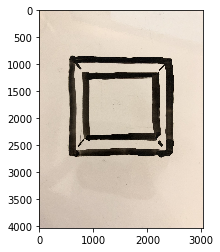

In [292]:
# print test image classified category
testing_image('images_to_predict/IMG_5264.jpg')


[[0. 0. 1. 0.]]
Predicted shape is Star


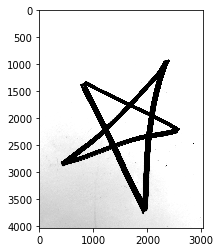

In [293]:
testing_image('images_to_predict/IMG_5269.jpg')


[[0. 0. 1. 0.]]
Predicted shape is Star


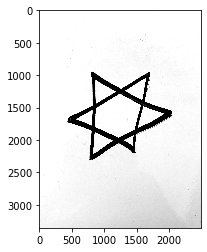

In [294]:
testing_image('images_to_predict/IMG_5268.jpg')
